# Torch Tools

The purpose of this notebook is to store useful snippets for PyTorch model training and analysis.

In [1]:
import torch
import torch.nn as nn
from torchsummary import summary
from torchviz import make_dot
import numpy as np
import time

import wandb
from torch.utils.tensorboard import SummaryWriter

import matplotlib.pyplot as plt
from tqdm import tqdm
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.model_selection import train_test_split
import random

## Torch Tensor Operations

Helpful and regularly used `torch` operations.

In [2]:
def device():
    return torch.device("cuda" if torch.cuda.is_available() else "cpu")


def torch_to_np_cpu(torch_tensor):
    return torch_tensor.detach().clone().cpu().numpy()


torch_cuda = torch.tensor([1, 2, 3]).to(device())
np_cpu = torch_to_np_cpu(torch_cuda)

## Sequential Models

Easy way to setup MLP and CNN models.

In [3]:
def mlp(num_inputs,
        num_outputs,
        hidden_layers,
        activation=nn.ReLU,
        output_activation=nn.Identity):
    layers = []
    layer_sizes = [num_inputs] + hidden_layers + [num_outputs]
    for i in range(len(layer_sizes) - 1):
        act = activation if i < len(layer_sizes) - 2 else output_activation
        layers += [nn.Linear(layer_sizes[i], layer_sizes[i + 1]), act()]
    return nn.Sequential(*layers)

In [4]:
def _cnn(input_shape,
         conv_channels,
         hidden_layers,
         output_dim,
         cnn_layer,
         activation=nn.ReLU,
         output_activation=nn.Identity):
    if len(input_shape) == 3:
        n_input_channels, input_height, input_width = input_shape
        input_dimensions = np.array([input_height, input_width])
    elif len(input_shape) == 4:
        n_input_channels, input_depth, input_height, input_width = input_shape
        input_dimensions = np.array([input_depth, input_height, input_width])
    else:
        raise ValueError(f"Invalid input_shape = {input_shape}")

    # Conv layers
    layers = []
    n_channels = [n_input_channels] + conv_channels
    for i in range(len(n_channels) - 1):
        layers += [
            cnn_layer(in_channels=n_channels[i],
                      out_channels=n_channels[i + 1],
                      kernel_size=3,
                      stride=1,
                      padding='same'),
            activation(),
            nn.MaxPool2d(kernel_size=2, stride=2)
        ]

    # Flatten
    layers.append(nn.Flatten(start_dim=1))

    # Prepare for linear layers
    n_pooling_layers = len(n_channels) - 1
    conv_layers_output_dimensions = input_dimensions // (2**n_pooling_layers)
    n_first_features = n_channels[-1] * np.prod(conv_layers_output_dimensions)

    # Linear layers
    layer_sizes = [n_first_features] + hidden_layers + [output_dim]
    for i in range(len(layer_sizes) - 1):
        act = activation if i < len(layer_sizes) - 2 else output_activation
        layers += [nn.Linear(layer_sizes[i], layer_sizes[i + 1]), act()]
    return nn.Sequential(*layers)

In [5]:
def cnn_2d(input_shape,
           conv_channels,
           hidden_layers,
           output_dim,
           activation=nn.ReLU,
           output_activation=nn.Identity):
    return _cnn(input_shape,
                conv_channels,
                hidden_layers,
                output_dim,
                activation=activation,
                output_activation=output_activation,
                cnn_layer=nn.Conv2d)


def cnn_3d(input_shape,
           conv_channels,
           hidden_layers,
           output_dim,
           activation=nn.ReLU,
           output_activation=nn.Identity):
    return _cnn(input_shape,
                conv_channels,
                hidden_layers,
                output_dim,
                activation=activation,
                output_activation=output_activation,
                cnn_layer=nn.Conv3d)

In [6]:
class MLP(nn.Module):

    def __init__(self,
                 num_inputs,
                 num_outputs,
                 hidden_layers,
                 activation=nn.ReLU,
                 output_activation=nn.Identity):
        super(MLP, self).__init__()
        self.mlp = mlp(num_inputs,
                       num_outputs,
                       hidden_layers,
                       activation=activation,
                       output_activation=output_activation)

    def forward(self, x):
        return self.mlp(x)

In [7]:
class CNN2d(nn.Module):

    def __init__(self,
                 input_shape,
                 conv_channels,
                 hidden_layers,
                 output_dim,
                 activation=nn.ReLU,
                 output_activation=nn.Identity):
        super(CNN2d, self).__init__()
        self.cnn_2d = cnn_2d(input_shape,
                             conv_channels,
                             hidden_layers,
                             output_dim,
                             activation=activation,
                             output_activation=output_activation)

    def forward(self, x):
        return self.cnn_2d(x)

In [8]:
mlp_num_inputs = 100
mlp_model = MLP(num_inputs=mlp_num_inputs,
                num_outputs=3,
                hidden_layers=[64, 64],
                activation=nn.ReLU,
                output_activation=nn.Identity).to(device())
mlp_model

MLP(
  (mlp): Sequential(
    (0): Linear(in_features=100, out_features=64, bias=True)
    (1): ReLU()
    (2): Linear(in_features=64, out_features=64, bias=True)
    (3): ReLU()
    (4): Linear(in_features=64, out_features=3, bias=True)
    (5): Identity()
  )
)

In [9]:
cnn_input_shape = (3, 128, 128)
cnn_model = CNN2d(input_shape=cnn_input_shape,
                  conv_channels=[8, 16, 32, 64],
                  hidden_layers=[128, 64],
                  output_dim=4,
                  activation=nn.ReLU,
                  output_activation=nn.Identity).to(device())
cnn_model

CNN2d(
  (cnn_2d): Sequential(
    (0): Conv2d(3, 8, kernel_size=(3, 3), stride=(1, 1), padding=same)
    (1): ReLU()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(8, 16, kernel_size=(3, 3), stride=(1, 1), padding=same)
    (4): ReLU()
    (5): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (6): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1), padding=same)
    (7): ReLU()
    (8): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (9): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=same)
    (10): ReLU()
    (11): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (12): Flatten(start_dim=1, end_dim=-1)
    (13): Linear(in_features=4096, out_features=128, bias=True)
    (14): ReLU()
    (15): Linear(in_features=128, out_features=64, bias=True)
    (16): ReLU()
    (17): Linear(in_features=64, out_features=4, bias=True)
    (18): Ident

## Model Information

Methods for understanding your model architecture better.

In [10]:
summary(mlp_model, input_size=(mlp_num_inputs, ))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Linear-1                   [-1, 64]           6,464
              ReLU-2                   [-1, 64]               0
            Linear-3                   [-1, 64]           4,160
              ReLU-4                   [-1, 64]               0
            Linear-5                    [-1, 3]             195
          Identity-6                    [-1, 3]               0
Total params: 10,819
Trainable params: 10,819
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.00
Forward/backward pass size (MB): 0.00
Params size (MB): 0.04
Estimated Total Size (MB): 0.04
----------------------------------------------------------------


In [11]:
summary(cnn_model, input_size=cnn_input_shape)

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1          [-1, 8, 128, 128]             224
              ReLU-2          [-1, 8, 128, 128]               0
         MaxPool2d-3            [-1, 8, 64, 64]               0
            Conv2d-4           [-1, 16, 64, 64]           1,168
              ReLU-5           [-1, 16, 64, 64]               0
         MaxPool2d-6           [-1, 16, 32, 32]               0
            Conv2d-7           [-1, 32, 32, 32]           4,640
              ReLU-8           [-1, 32, 32, 32]               0
         MaxPool2d-9           [-1, 32, 16, 16]               0
           Conv2d-10           [-1, 64, 16, 16]          18,496
             ReLU-11           [-1, 64, 16, 16]               0
        MaxPool2d-12             [-1, 64, 8, 8]               0
          Flatten-13                 [-1, 4096]               0
           Linear-14                  [

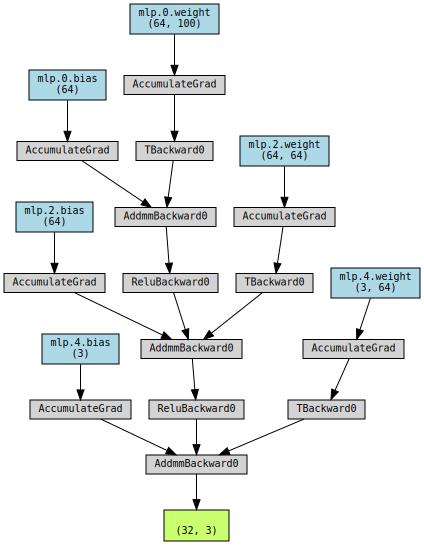

In [12]:
batch_size = 32
mlp_example_input = torch.randn(batch_size, mlp_num_inputs).to(device())
make_dot(mlp_model(mlp_example_input),
         params=dict(mlp_model.named_parameters()))

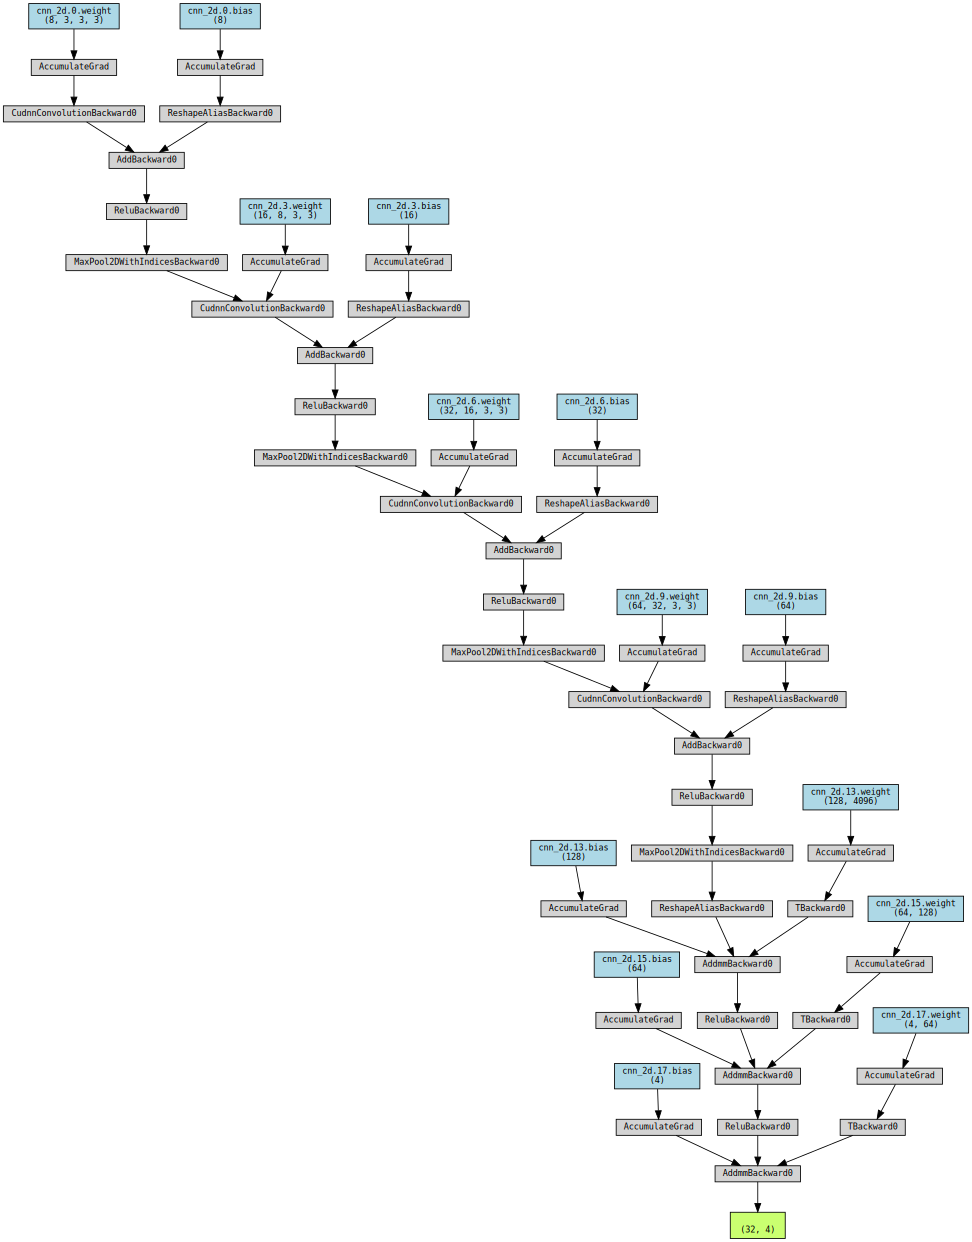

In [13]:
batch_size = 32
cnn_example_input = torch.randn(batch_size, *cnn_input_shape).to(device())
make_dot(cnn_model(cnn_example_input),
         params=dict(cnn_model.named_parameters()))

## Set Random Seed

In [14]:
def set_seed(seed):
    random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    np.random.seed(seed)
    torch.set_num_threads(1)

In [15]:
set_seed(10)

## Timer

In [16]:
class Timer():

    def __init__(self,
                 name_of_timed_commands,
                 get_current_time_fn=time.perf_counter):
        self.name = name_of_timed_commands
        self.get_current_time_fn = get_current_time_fn

    def __enter__(self):
        self.start = self.get_current_time_fn()
        return self

    def __exit__(self, type, value, traceback):
        print(
            f"Time elapsed for '{self.name}' is {self.get_current_time_fn() - self.start} seconds"
        )

In [17]:
with Timer("Test sleep"):
    time.sleep(5)

Time elapsed for 'Test sleep' is 5.0045245889996295 seconds


In [18]:
with Timer("Test sleep", get_current_time_fn=time.time):
    time.sleep(5)

Time elapsed for 'Test sleep' is 5.004176378250122 seconds


## Configuration/Hyperparameter Dict

In [19]:
class PARAMS:
    N_DATAPTS = 100
    N_FEATURES = 10
    N_CLASSES = 4

    N_EPOCHS = 100
    BATCH_SIZE = 32
    lr = 1e-4
    hidden_layers = [8, 8]

In [20]:
def get_fields_to_values_map(class_, types=[int, float, str, bool]):
    """
    For the given class instance, create a dict mappings its attribute names to attribute values
    if correct type
    """

    def is_type(value, types):
        return np.any([isinstance(value, t) for t in types])

    fields = [
        f for f in dir(class_)
        if not f.startswith('_') and not callable(getattr(class_, f))
    ]
    fields_to_values_map = {
        f: getattr(class_, f)
        for f in fields if is_type(getattr(class_, f), types)
    }
    return fields_to_values_map


def get_list_fields_to_values_map(class_, max_list_size=5):
    """
    For the given class instance, create a dict mappings its attribute names to list attribute values
    Converts a list of up to len max_list_size do a dict of {"list0": 0, "list1": 1, ...}
    """
    fields_to_list_values_map = get_fields_to_values_map(class_, types=[list])
    fields_to_list_values_map = {
        field: list_[:max_list_size]
        for field, list_ in fields_to_list_values_map.items()
    }
    fields_to_list_values_map = {
        f'{field}-{i}': list_[i]
        for field, list_ in fields_to_list_values_map.items()
        for i in range(len(list_))
    }
    return fields_to_list_values_map

In [21]:
# Get dict from class
params = {}
params.update(get_fields_to_values_map(PARAMS))
params.update(get_list_fields_to_values_map(PARAMS))
print(f"params = {params}")

params = {'BATCH_SIZE': 32, 'N_CLASSES': 4, 'N_DATAPTS': 100, 'N_EPOCHS': 100, 'N_FEATURES': 10, 'lr': 0.0001, 'hidden_layers-0': 8, 'hidden_layers-1': 8}


In [22]:
# Log to wandb or tensorboard

# wandb.init(entity='tylerlum', project='testing', reinit=True)
# wandb.config.update(params)

# writer = SummaryWriter('testing/test1')
# writer.add_hparams(hparam_dict=params)

## Creating Dataset

In [23]:
# Create dataset
X = torch.randn(PARAMS.N_DATAPTS, PARAMS.N_FEATURES).to(device())
y = torch.randint(low=0, high=PARAMS.N_CLASSES, size=(PARAMS.N_DATAPTS,)).to(device())

dataset = []
for i in range(PARAMS.N_DATAPTS):
    dataset.append((X[i], y[i]))

In [24]:
# Train-Val-Test Split
dataset_train_val, dataset_test = train_test_split(dataset, test_size=0.2)
dataset_train, dataset_val = train_test_split(dataset_train_val, test_size=0.2)

print(f"len(dataset_train) = {len(dataset_train)}")
print(f"len(dataset_val) = {len(dataset_val)}")
print(f"len(dataset_test) = {len(dataset_test)}")

len(dataset_train) = 64
len(dataset_val) = 16
len(dataset_test) = 20


In [25]:
# Create dataloaders
train_loader = torch.utils.data.DataLoader(dataset_train,
                                           batch_size=PARAMS.BATCH_SIZE,
                                           shuffle=True)
val_loader = torch.utils.data.DataLoader(dataset_val,
                                         batch_size=PARAMS.BATCH_SIZE,
                                         shuffle=True)
test_loader = torch.utils.data.DataLoader(dataset_test,
                                          batch_size=PARAMS.BATCH_SIZE,
                                          shuffle=True)

## Confusion Matrix

In [26]:
def create_confusion_matrix_from_xy(model, X, y_true, title=None):
    y_pred = torch.argmax(model(X), dim=1)
    cm = confusion_matrix(y_true=torch_to_np_cpu(y_true),
                          y_pred=torch_to_np_cpu(y_pred))
    cm_display = ConfusionMatrixDisplay(
        confusion_matrix=cm,
        display_labels=[i for i in range(PARAMS.N_CLASSES)])
    cm_display = cm_display.plot()
    if title is not None:
        cm_display.ax_.set_title(title)
    return cm_display.figure_


def create_confusion_matrix_from_data(model, data, title=None):
    X = torch.stack([x for x, _ in data], dim=0)
    y = torch.stack([y for _, y in data], dim=0)
    return create_confusion_matrix_from_xy(model, X, y, title)

## Create Training Loop

In [27]:
# Train loop
optimizer = torch.optim.Adam(mlp_model.parameters(), lr=PARAMS.lr)

# Can change for unbalanced dataset
class_weights = torch.ones(PARAMS.N_CLASSES).to(device())
loss_fn = nn.CrossEntropyLoss(weight=class_weights)

  9%|███████████▋                                                                                                                      | 9/100 [00:00<00:07, 12.97it/s]/home/tylerlum/miniconda3/envs/rlgpu/lib/python3.7/site-packages/sklearn/metrics/_plot/confusion_matrix.py:125: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig, ax = plt.subplots()
100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:07<00:00, 13.32it/s]


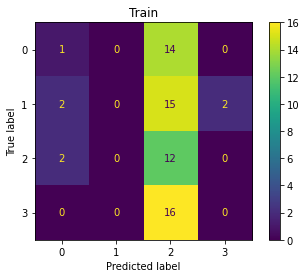

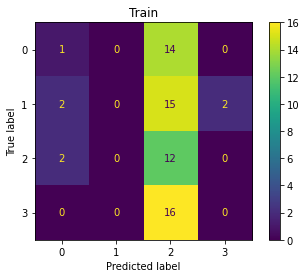

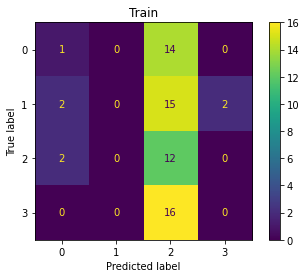

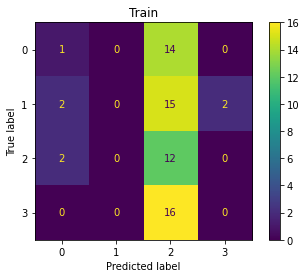

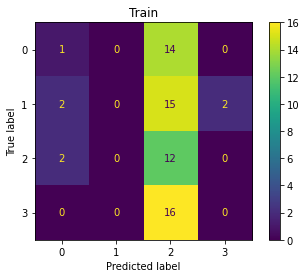

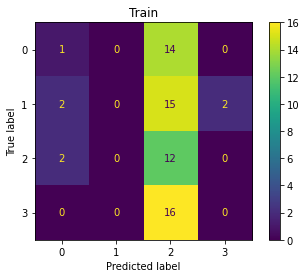

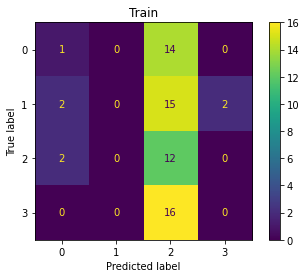

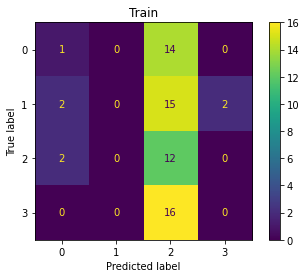

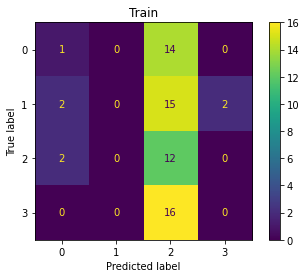

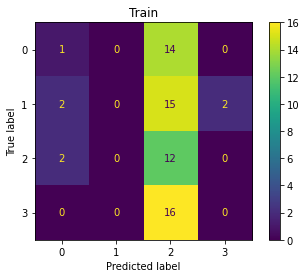

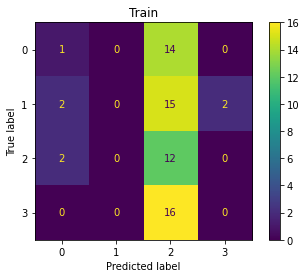

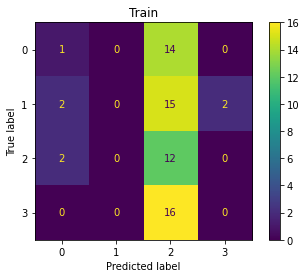

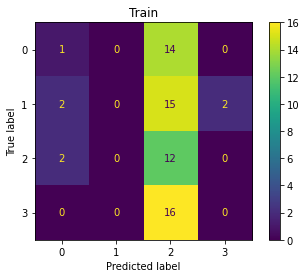

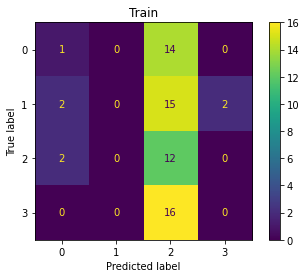

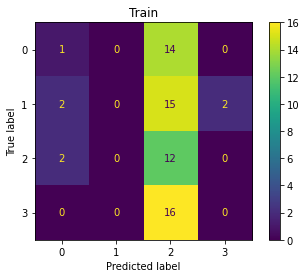

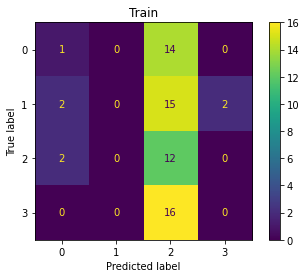

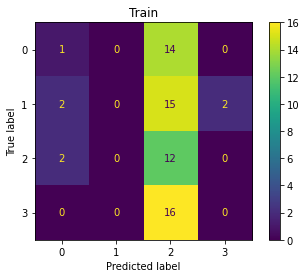

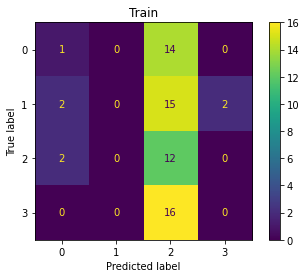

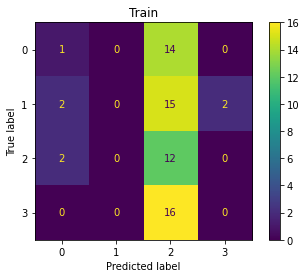

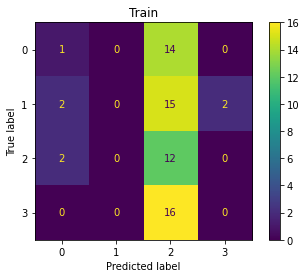

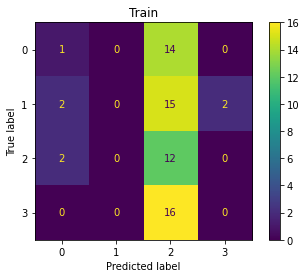

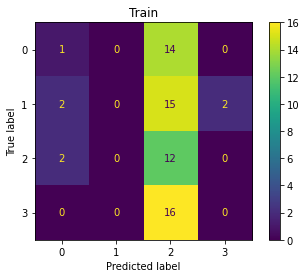

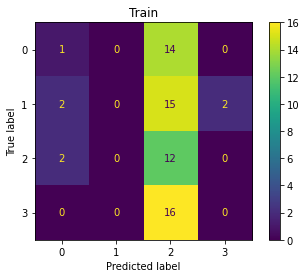

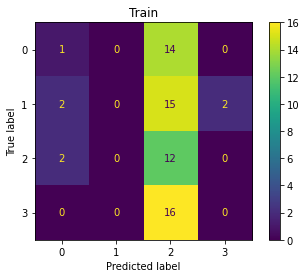

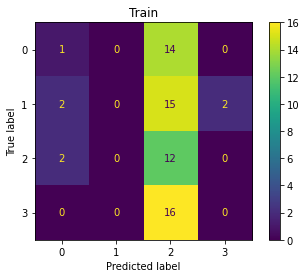

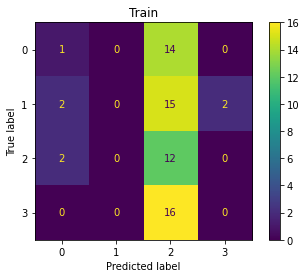

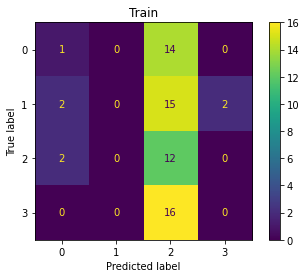

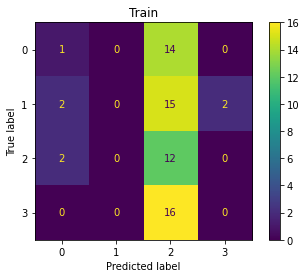

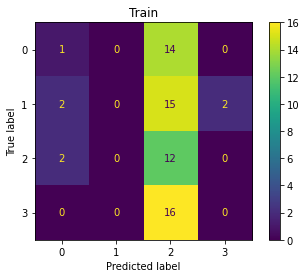

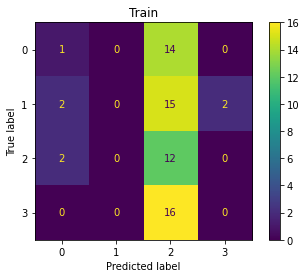

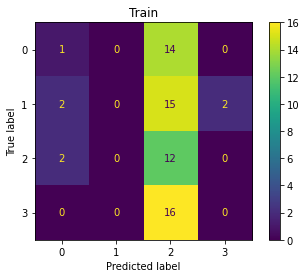

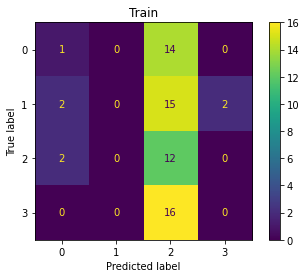

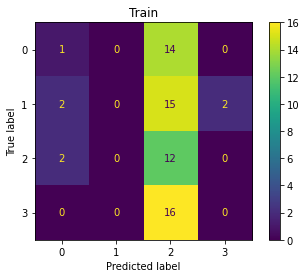

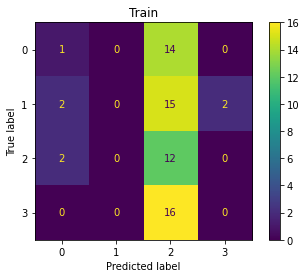

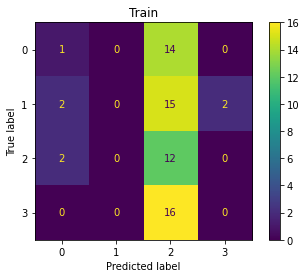

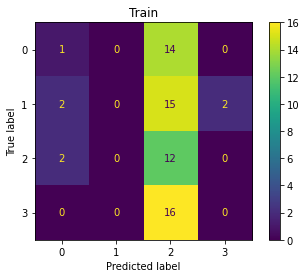

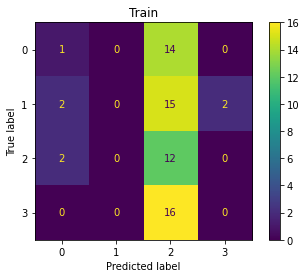

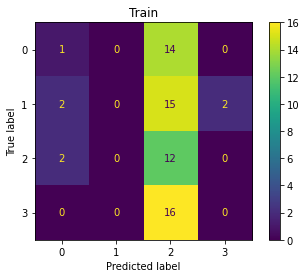

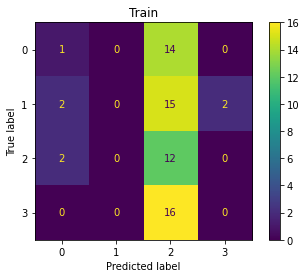

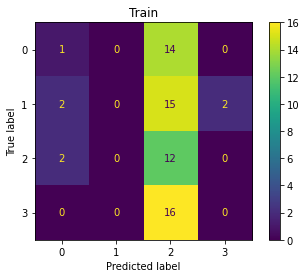

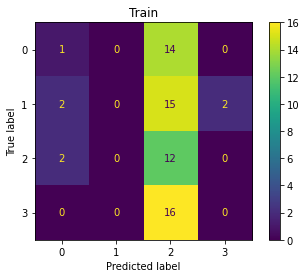

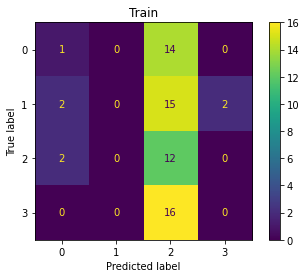

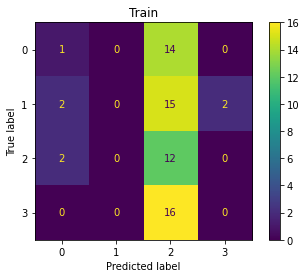

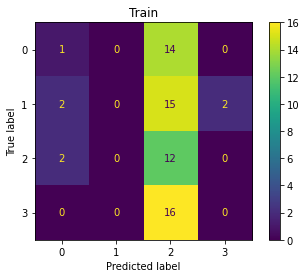

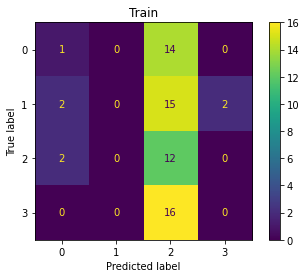

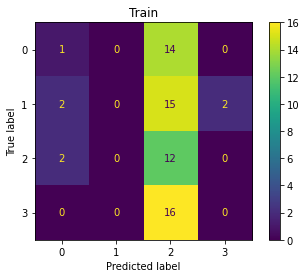

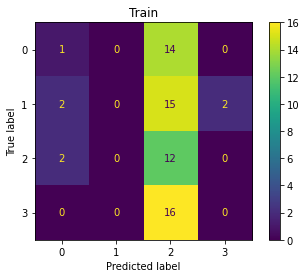

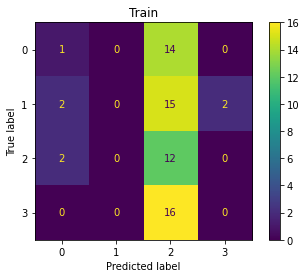

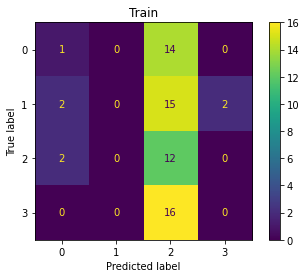

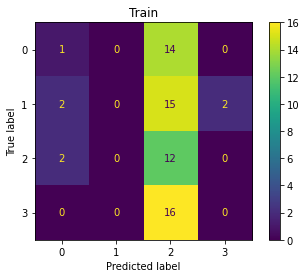

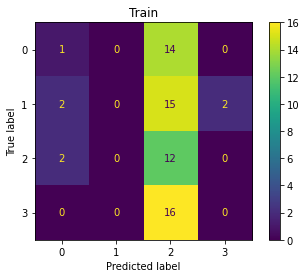

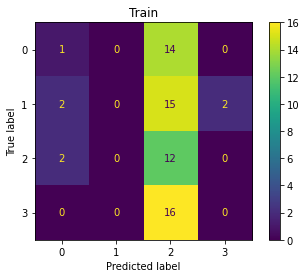

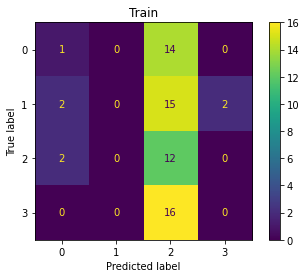

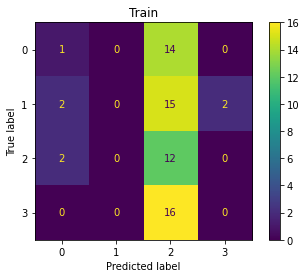

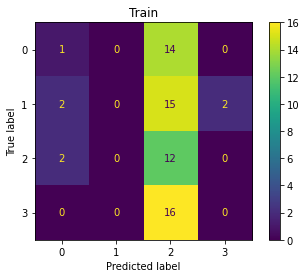

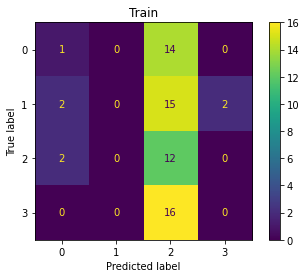

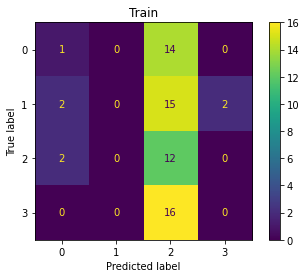

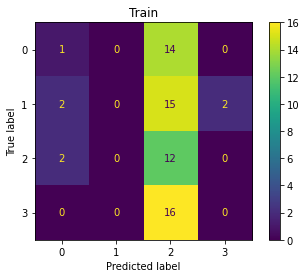

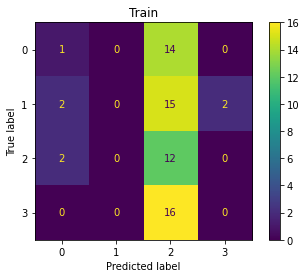

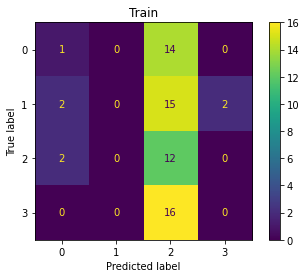

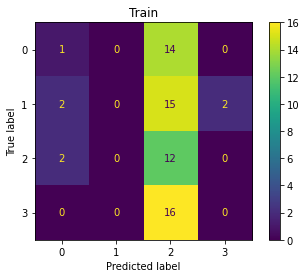

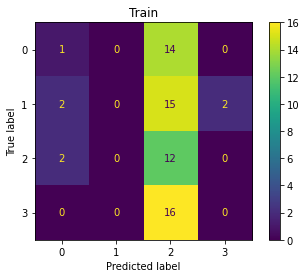

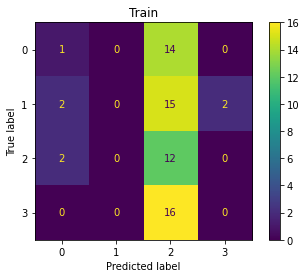

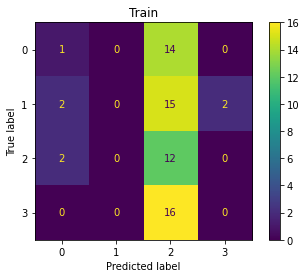

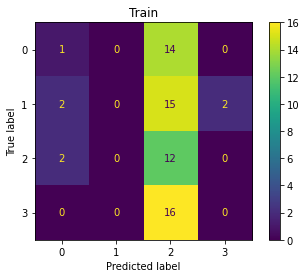

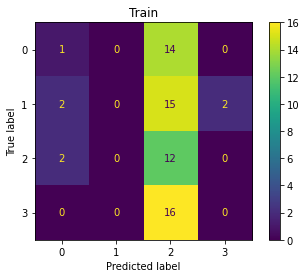

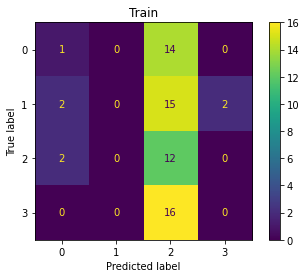

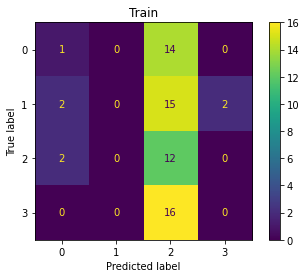

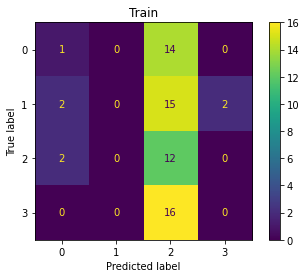

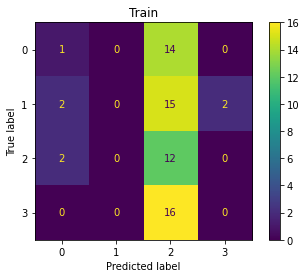

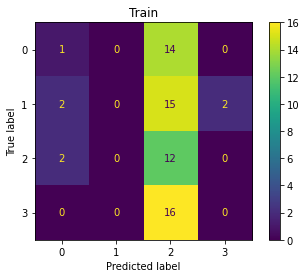

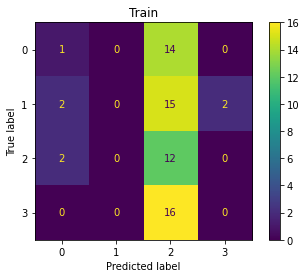

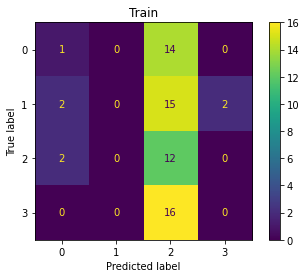

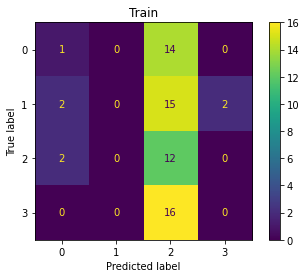

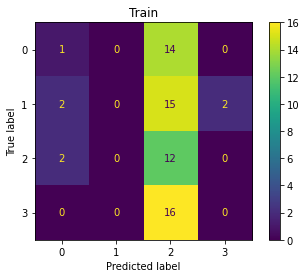

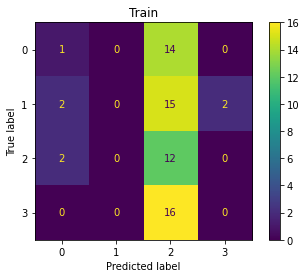

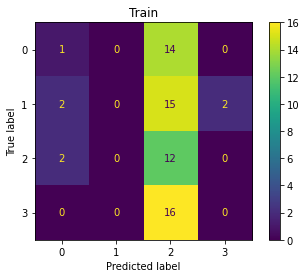

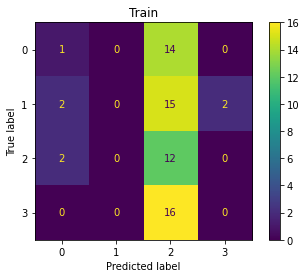

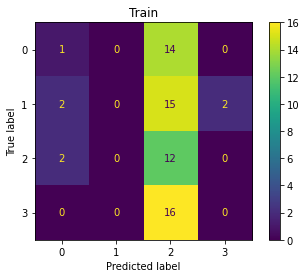

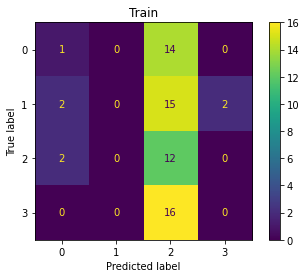

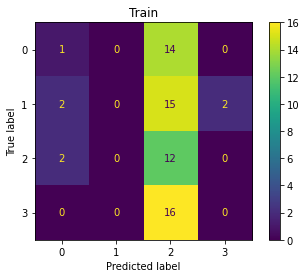

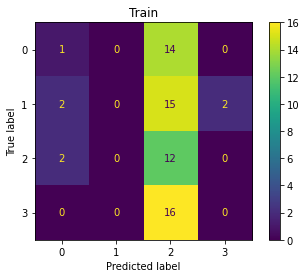

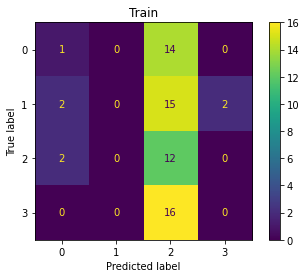

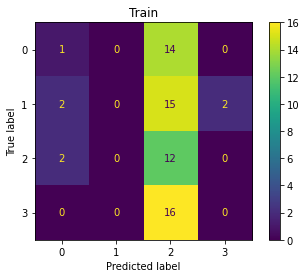

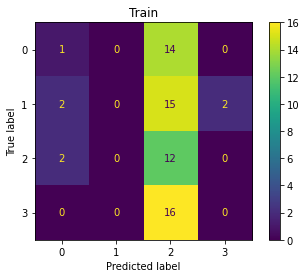

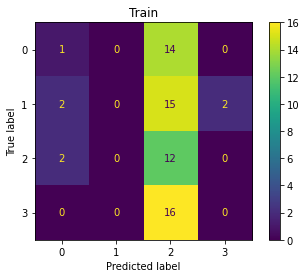

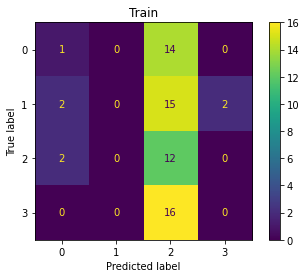

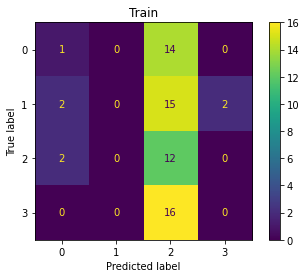

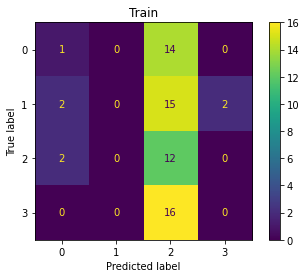

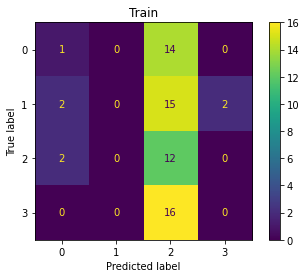

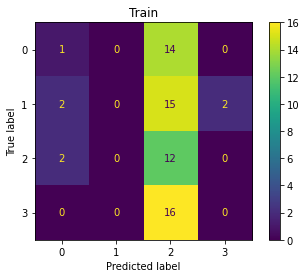

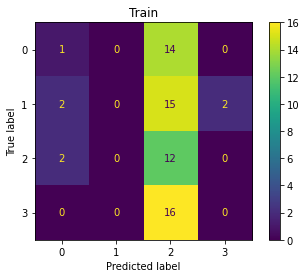

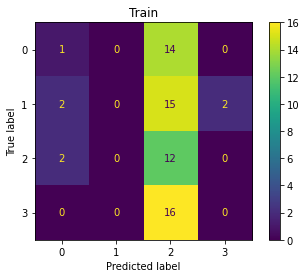

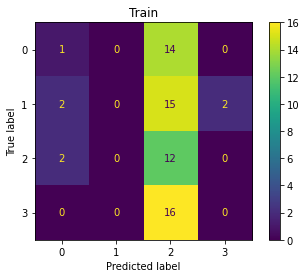

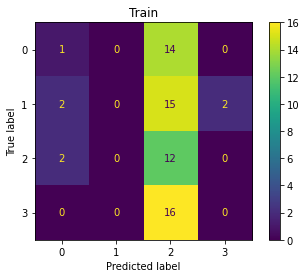

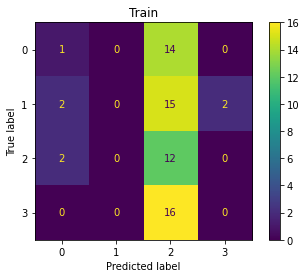

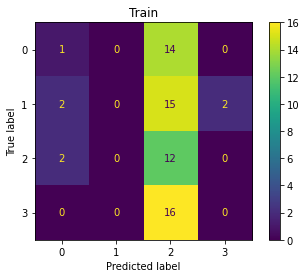

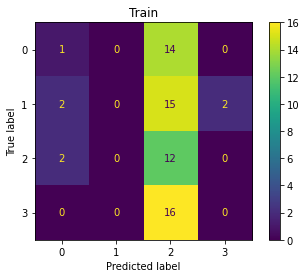

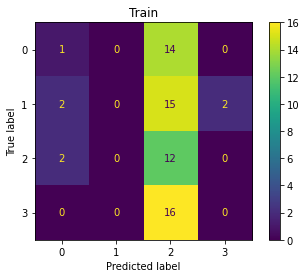

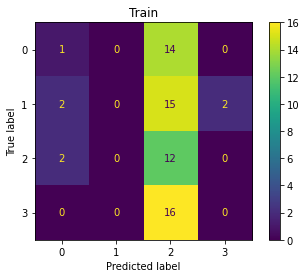

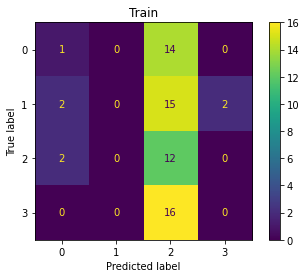

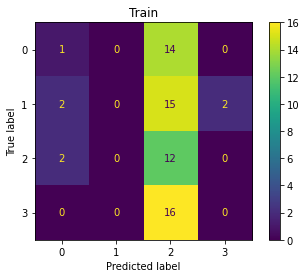

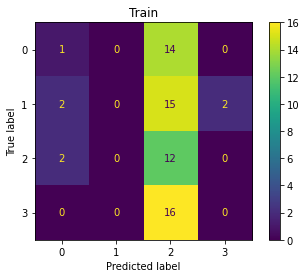

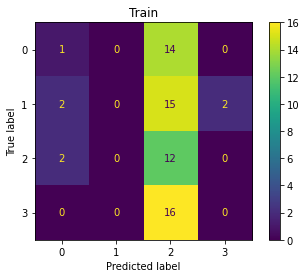

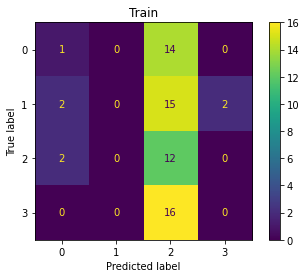

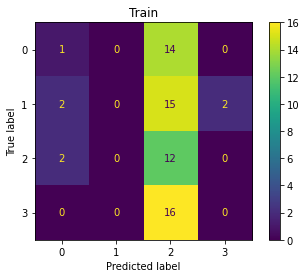

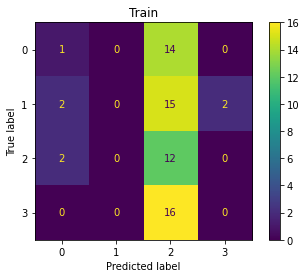

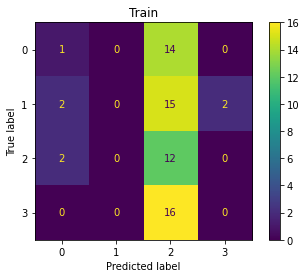

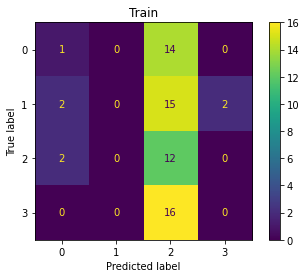

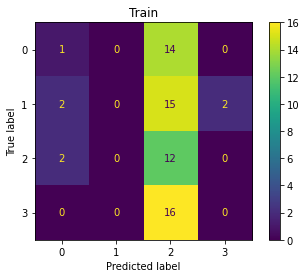

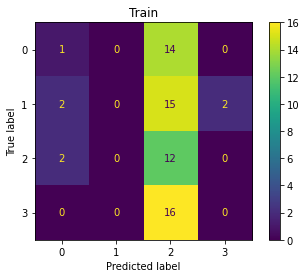

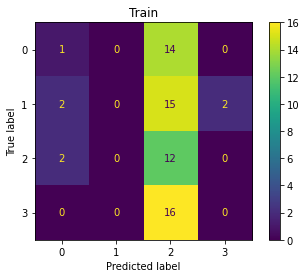

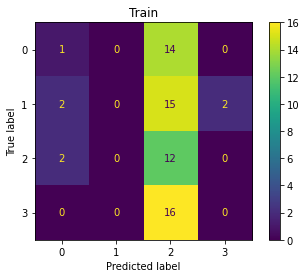

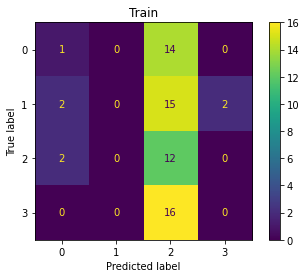

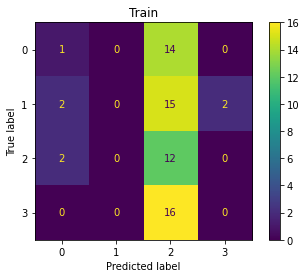

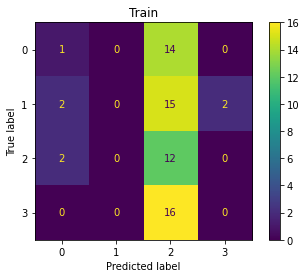

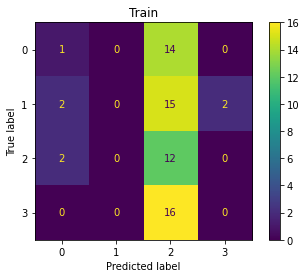

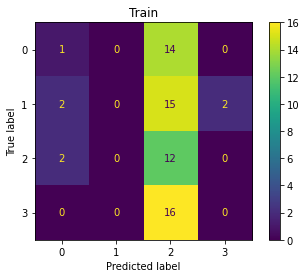

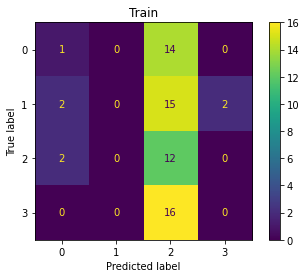

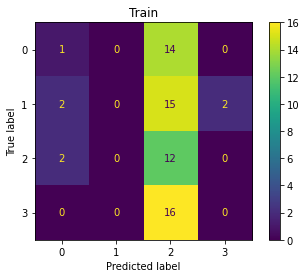

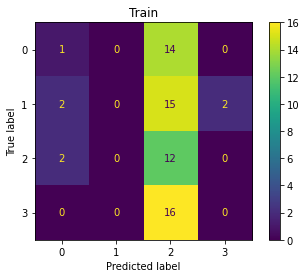

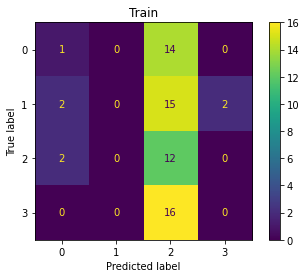

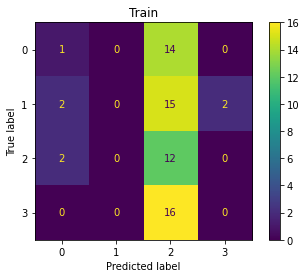

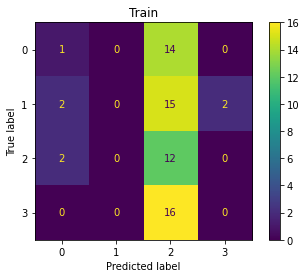

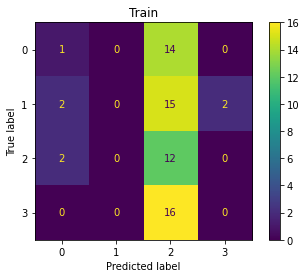

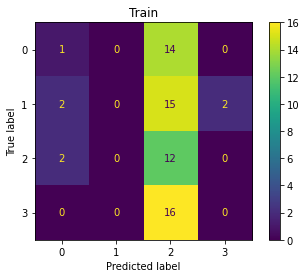

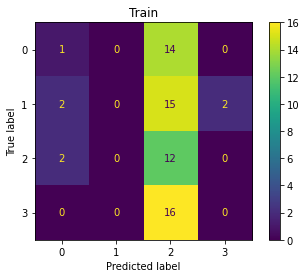

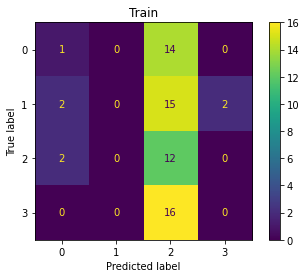

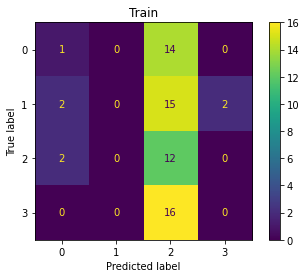

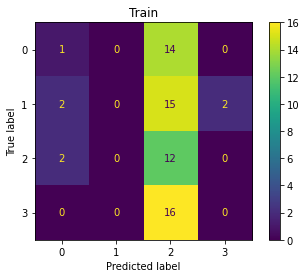

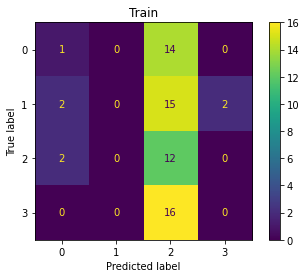

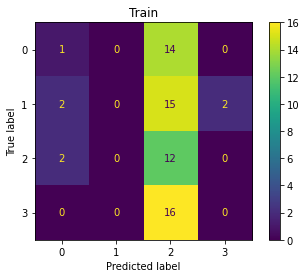

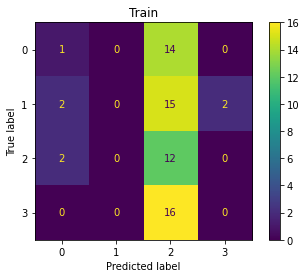

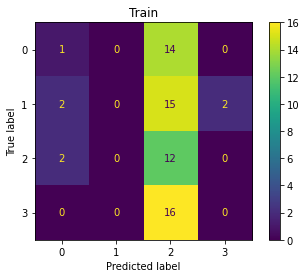

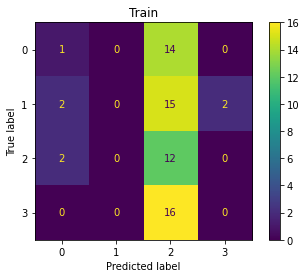

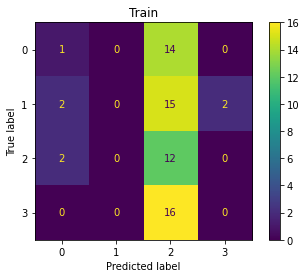

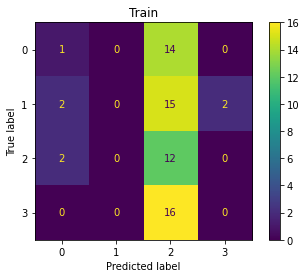

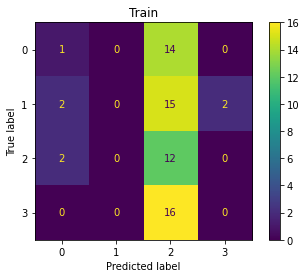

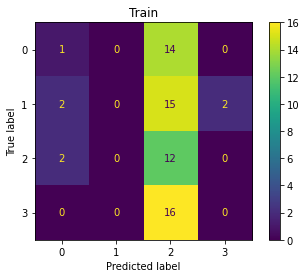

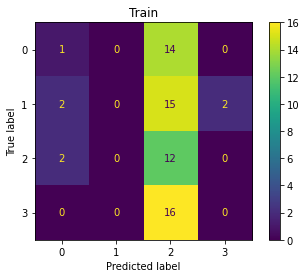

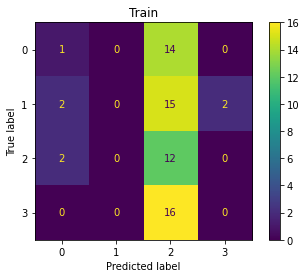

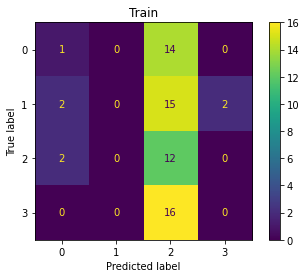

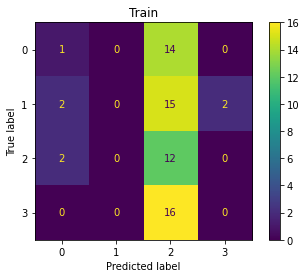

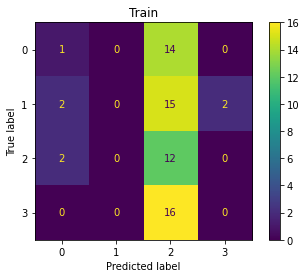

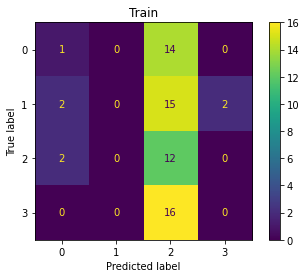

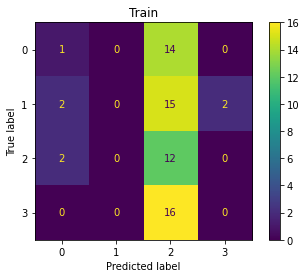

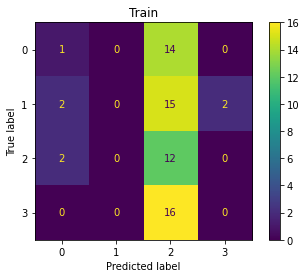

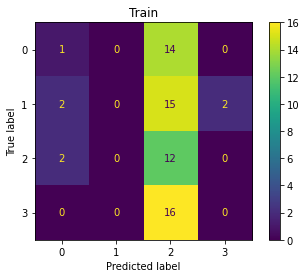

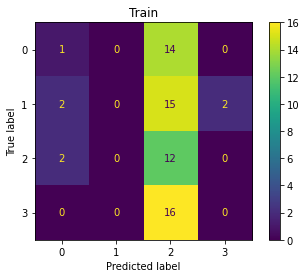

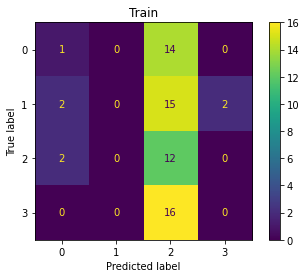

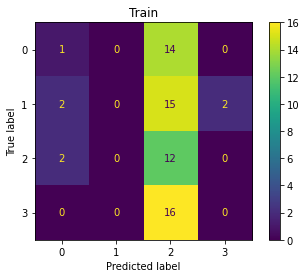

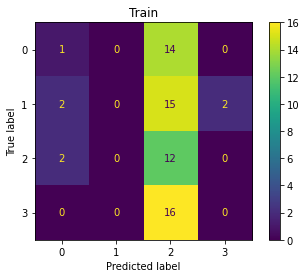

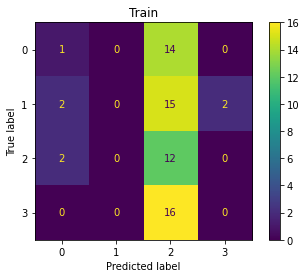

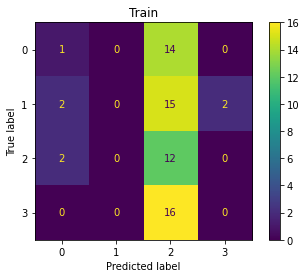

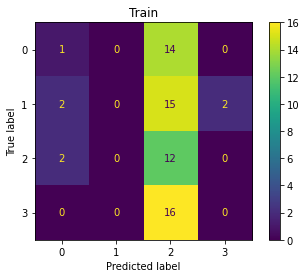

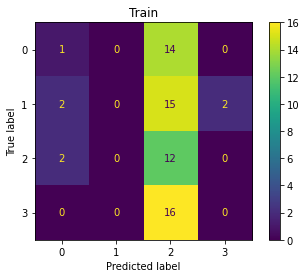

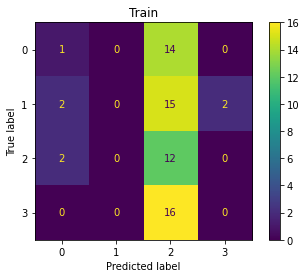

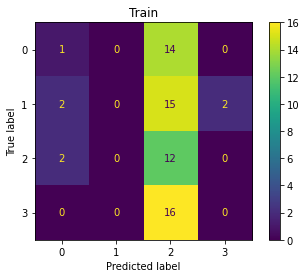

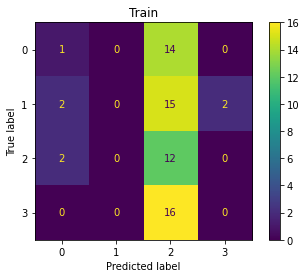

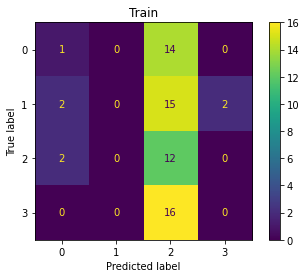

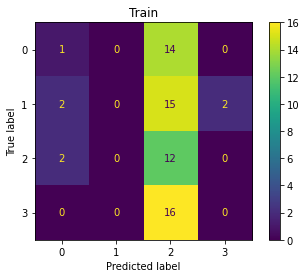

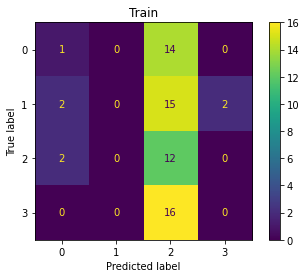

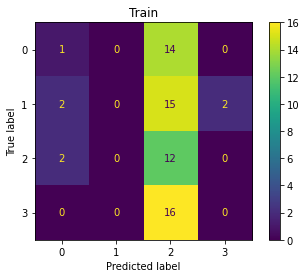

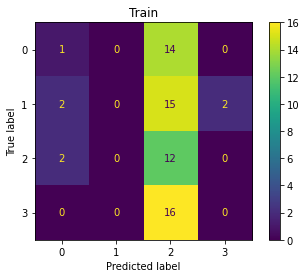

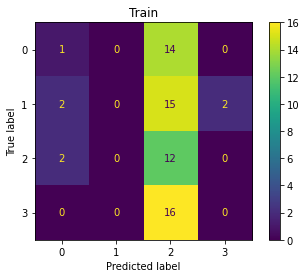

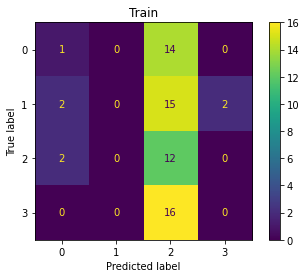

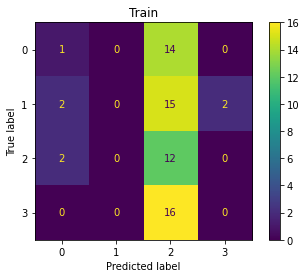

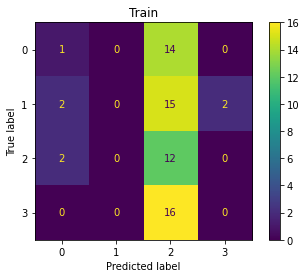

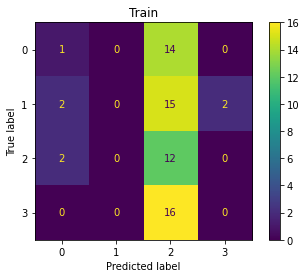

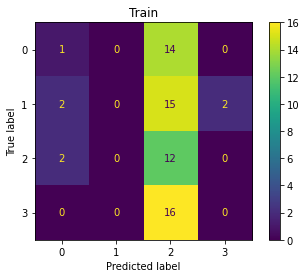

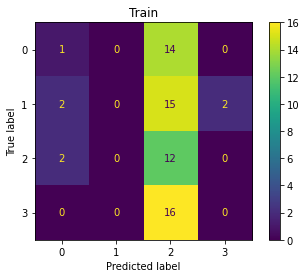

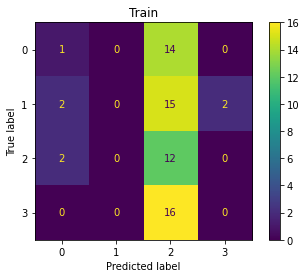

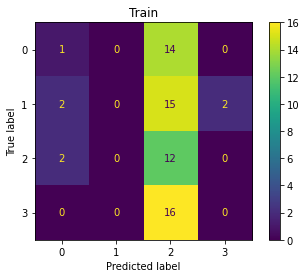

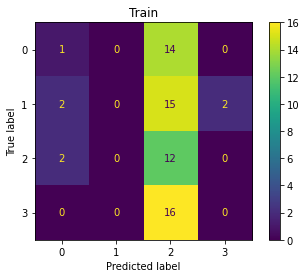

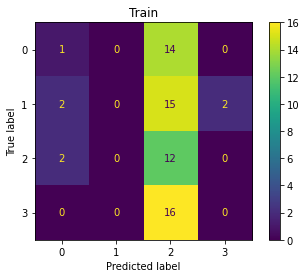

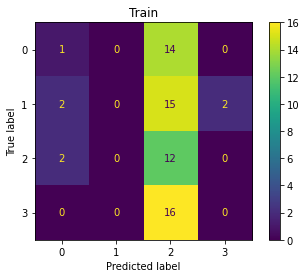

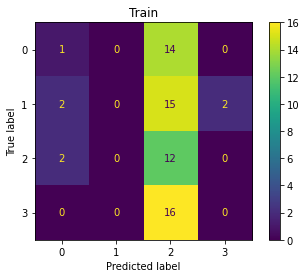

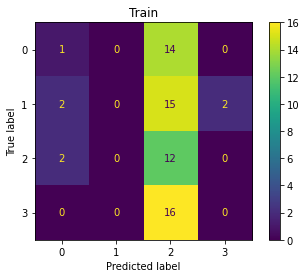

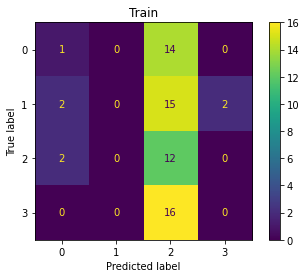

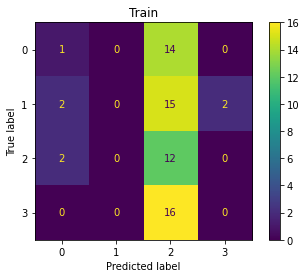

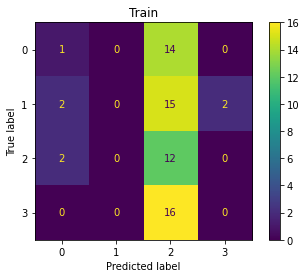

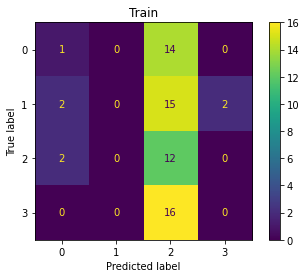

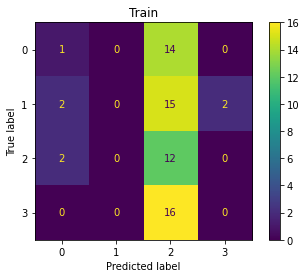

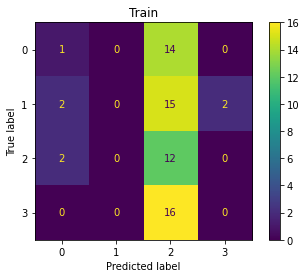

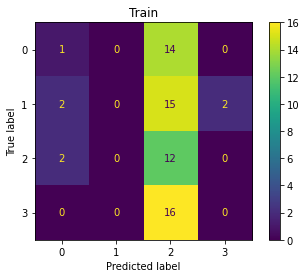

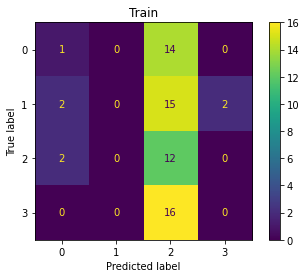

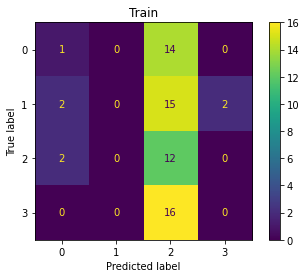

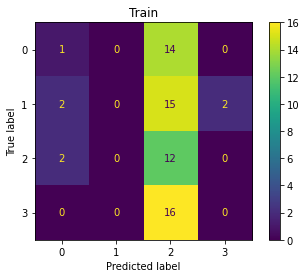

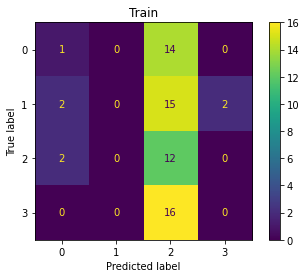

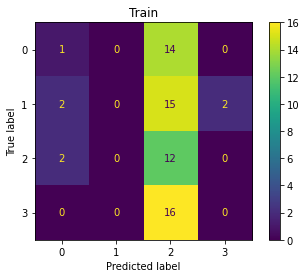

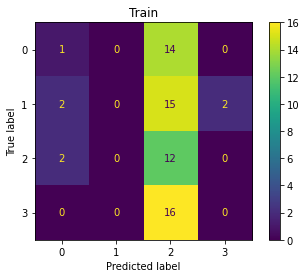

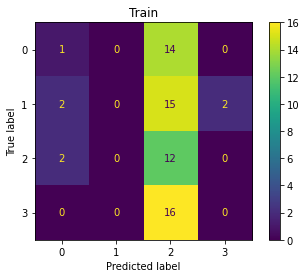

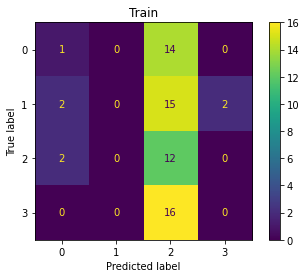

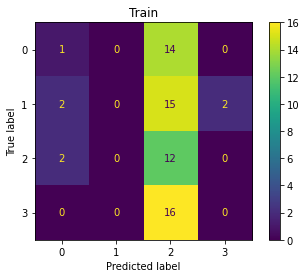

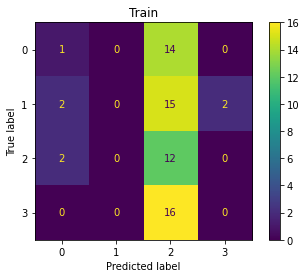

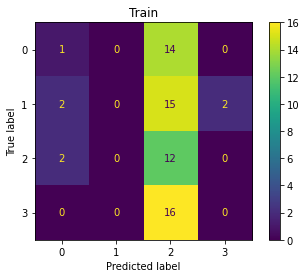

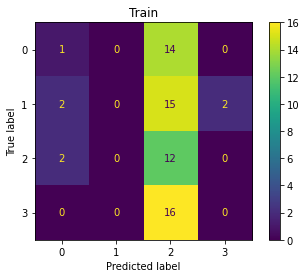

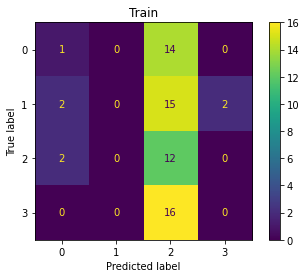

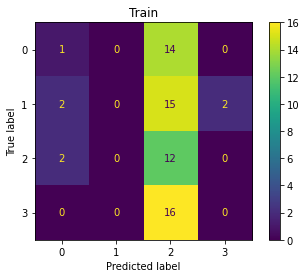

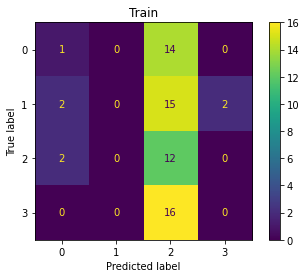

In [28]:
model = MLP(num_inputs=PARAMS.N_FEATURES,
            num_outputs=PARAMS.N_CLASSES,
            hidden_layers=PARAMS.hidden_layers).to(device())

for epoch in tqdm(range(PARAMS.N_EPOCHS)):
    log_dict = {}

    # Train
    train_losses = []
    for i, (x, y) in enumerate(train_loader):
        # Compute loss
        y_hat = model(x)
        train_loss = loss_fn(input=y_hat, target=y)

        # Backprop
        optimizer.zero_grad()
        train_loss.backward()
        optimizer.step()

        # Store
        train_losses.append(train_loss.item())

    log_dict['train_loss'] = np.mean(train_losses)
    log_dict['train_confusion_matrix'] = create_confusion_matrix_from_data(
        model, dataset_train, title='Train')

    # Validation
    val_losses = []
    for i, (x, y) in enumerate(val_loader):
        # Compute loss
        y_hat = model(x)
        val_loss = loss_fn(input=y_hat, target=y)

        # Store
        val_losses.append(val_loss.item())

    log_dict['val_loss'] = np.mean(val_losses)
    log_dict['train_confusion_matrix'] = create_confusion_matrix_from_data(
        model, dataset_train, title='Train')

    # Log to wandb or tensorboard
    # wandb.log(log_dict)

    # for name, val in log_dict.items():
    #     writer.add_scalar(name, val, global_step=epoch)

## Plotting Many Images

In [29]:
def show_images(images, titles=None):
    """
    Displays images in given shape with subplots

    Args:
      * images. Either m x n image, or list of m x n images, or a grid of m x n images
      * titles. Either None or 1 str, or list of strs, or grid of strs
    """
    images = np.array(images)
    n_dims = len(images.shape)

    # Invalid
    if n_dims > 4 or n_dims < 2:
        raise ValueError("Invalid dimension for images: {n_dims}")

    h, w = images.shape[-2:]

    # 1 image
    if n_dims == 2:
        plt.imshow(images)
        plt.title(titles)
        return

    if n_dims == 3:
        nrows, ncols = 1, images.shape[0]
    else:
        nrows, ncols = images.shape[:2]

    figwidth, figheight = 5, 5
    fig, axes = plt.subplots(nrows=nrows,
                             ncols=ncols,
                             figsize=(ncols * figwidth, nrows * figheight))

    images = images.reshape(nrows, ncols, h, w)
    axes = axes.reshape(nrows, ncols)
    titles = None if titles is None else np.array(titles).reshape(nrows, ncols)
    assert (images.shape[:2] == (nrows, ncols))
    for r in range(nrows):
        for c in range(ncols):
            x = axes[r, c].imshow(images[r, c])
            if titles is not None:
                axes[r, c].set_title(titles[r][c])
            fig.colorbar(x, ax=axes[r, c], shrink=0.6)
    return fig

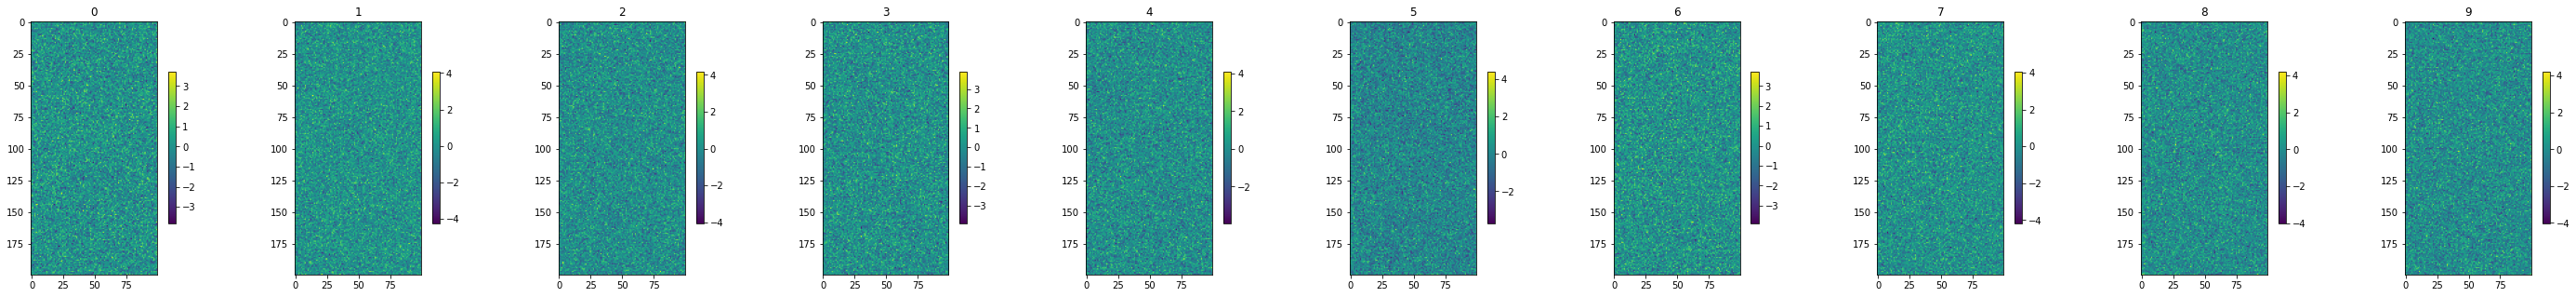

In [30]:
%matplotlib inline
images = [np.random.randn(200, 100) for _ in range(10)]
fig = show_images(images, titles=np.arange(len(images)))

## 3D Plots

<IPython.core.display.Javascript object>


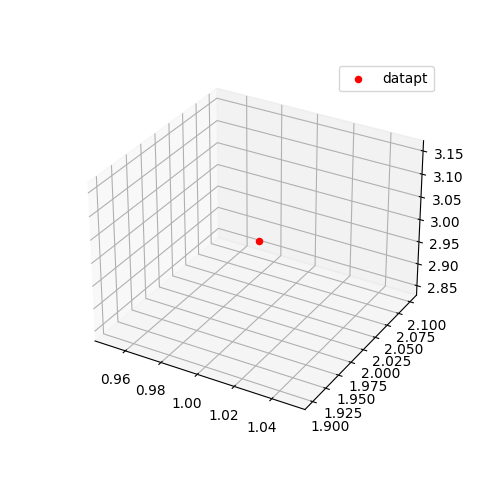

In [31]:
# Required to be interactive
%matplotlib notebook

fig = plt.figure(figsize=(5, 5))
ax = plt.axes(projection='3d')

ax.scatter3D(1, 2, 3, color='red', label='datapt')
ax.legend()